In [19]:
import numpy as np
import pymc3 as pm

import pickle
from datetime import datetime


import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.models import add_cms_to_plot
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

sns.set_style("ticks")
%matplotlib inline

In [20]:
def produce_CIs(data):
    means = np.median(data, axis=0)
    li = np.percentile(data, 2.5, axis=0)
    ui = np.percentile(data, 97.5, axis=0)
    err = np.array([means - li, ui - means])
    return means, li, ui, err

In [21]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("../final_data/data_final.csv")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Healthcare Infection Control
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


In [22]:
class ResultsObject():
    def __init__(self, indxs, trace):
        self.CMReduction = trace.CMReduction
        self.RegionLogR = trace.RegionLogR[:, indxs]
        self.InfectedCases = trace.InfectedCases[:, indxs, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indxs, :]
        self.ExpectedCases = trace.ExpectedCases[:, indxs, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indxs, :]
        self.Phi = trace.Phi_1
        
def mask_region(d, region, days=14):
    i = d.Rs.index(region)
    c_s = np.nonzero(np.cumsum(d.NewCases.data[i, :] > 0) == days + 1)[0][0]
    d_s = np.nonzero(np.cumsum(d.NewDeaths.data[i, :] > 0) == days + 1)[0]
    if len(d_s) > 0:
        d_s = d_s[0]
    else:
        d_s = len(d.Ds)

    d.Active.mask[i, c_s:] = True
    d.Confirmed.mask[i, c_s:] = True
    d.Deaths.mask[i, d_s:] = True
    d.NewDeaths.mask[i, d_s:] = True
    d.NewCases.mask[i, c_s:] = True

    return c_s, d_s

In [23]:
folds = [['DE', 'HU', 'FI', 'IE', 'RS', 'BE'],
         ['DK', 'GR', 'NO', 'FR', 'RO', 'MA'],
         ['ES', 'CZ', 'NL', 'CH', 'PT', 'AT'],
         ['IL', 'SE', 'IT', 'MX', 'GB', 'PL']]

journal: Cases: -0.1951 Deaths: -0.1719
noisyr: Cases: -0.1972 Deaths: -0.1887
journal-nonoise: Cases: -0.2019 Deaths: -0.1907
icl: Cases: -0.1968 Deaths: -0.1743
icl no noise: Cases: 0.0000 Deaths: -0.1712
diff effects: Cases: -0.1943 Deaths: -0.1808
additive: Cases: -0.1944 Deaths: -0.1717


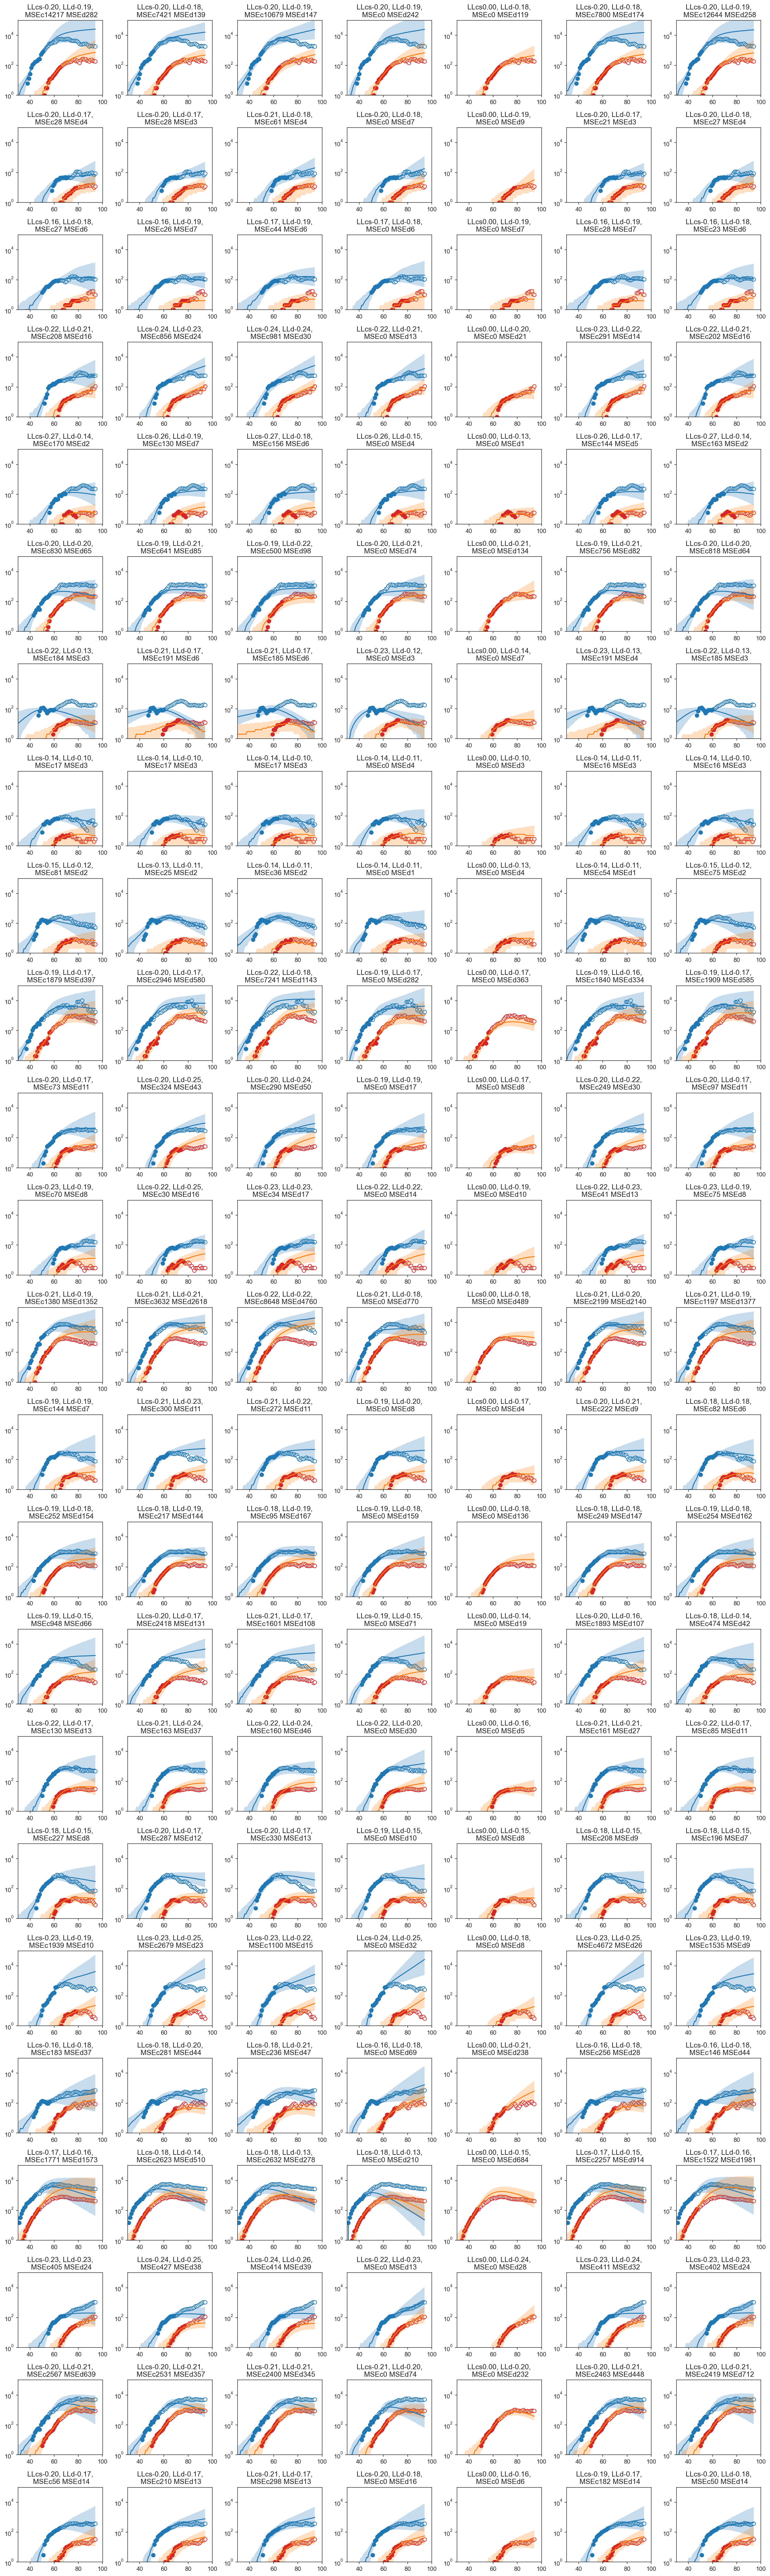

In [14]:
plt.figure(figsize=(18, 60), dpi=150)
model_names = ["journal", "noisyr", "discrete renewal", "diff effects", "additive"]
for model in [0, 1, 2, 3, 4]:
    ll1 = 0
    ll2 = 0
    c_ds = 0
    d_ds = 0
    for fold in [0, 1, 2, 3]:
        rs = folds[fold]
        res = pickle.load(open(f"model_{model}_fold_{fold}.pkl", "rb"))   
        alpha = np.mean(res.Phi)
        for i, r in enumerate(rs):
            r_i = data.Rs.index(r)
            c_s, d_s = mask_region(data, r)
            n_cds = len(data.Ds) - c_s
            n_dds = len(data.Ds) - d_s
            
            ll1_inc = 0
            ll2_inc = 0
            mse1 = 0
            
            if model != 2:
                ec = res.ExpectedCases[:, i, :]
                dist = pm.NegativeBinomial.dist(mu=ec, alpha=np.mean(res.Phi))
                ec_output = dist.random()

                plt.plot(np.arange(len(data.Ds)), np.median(ec_output, axis=0), color="tab:blue")
                plt.fill_between(np.arange(len(data.Ds)), np.percentile(ec_output,  2.5, axis=0) , np.percentile(ec_output,  97.5, axis=0), alpha=0.25, color="tab:blue", linewidth=0)
                plt.scatter(np.arange(len(data.Ds)), data.NewCases.data[r_i, :], edgecolor="tab:blue",
                facecolor="white", zorder=-1)
                plt.scatter(np.arange(len(data.Ds)), data.NewCases[r_i, :], edgecolor="tab:blue", facecolor="tab:blue", zorder=-1)

                conf_dist = pm.NegativeBinomial.dist(mu=res.ExpectedCases[:, i, c_s:], alpha=np.repeat(res.Phi.reshape((8000, 1)), n_cds, axis=1))     
                try:
                    ll1_inc = np.sum(np.log(np.mean(np.exp(conf_dist.logp(data.NewCases.data[r_i, c_s:].reshape((1, n_cds))).eval()))))
                except:
                    print(f"model: {model_names[model]}, region: {r}")
                    ll1_inc = 0


            ed = res.ExpectedDeaths[:, i, :]
            dist = pm.NegativeBinomial.dist(mu=ed, alpha=np.mean(res.Phi))
            ed_output = dist.random()

            death_dist = pm.NegativeBinomial.dist(mu=res.ExpectedDeaths[:, i, d_s:], alpha=np.repeat(res.Phi.reshape((8000, 1)), n_dds, axis=1))     
            ll2_inc = np.sum(np.log(np.mean(np.exp(death_dist.logp(data.NewDeaths.data[r_i, d_s:].reshape((1, n_dds))).eval()))))


                
            ll1 += ll1_inc
            ll2 += ll2_inc
            c_ds += n_cds
            d_ds += n_dds
            
    print(f"{model_names[model]}: Cases: {np.mean(ll1)/(c_ds):.4f} Deaths: {np.mean(ll2)/(d_ds):.4f}")
plt.tight_layout()

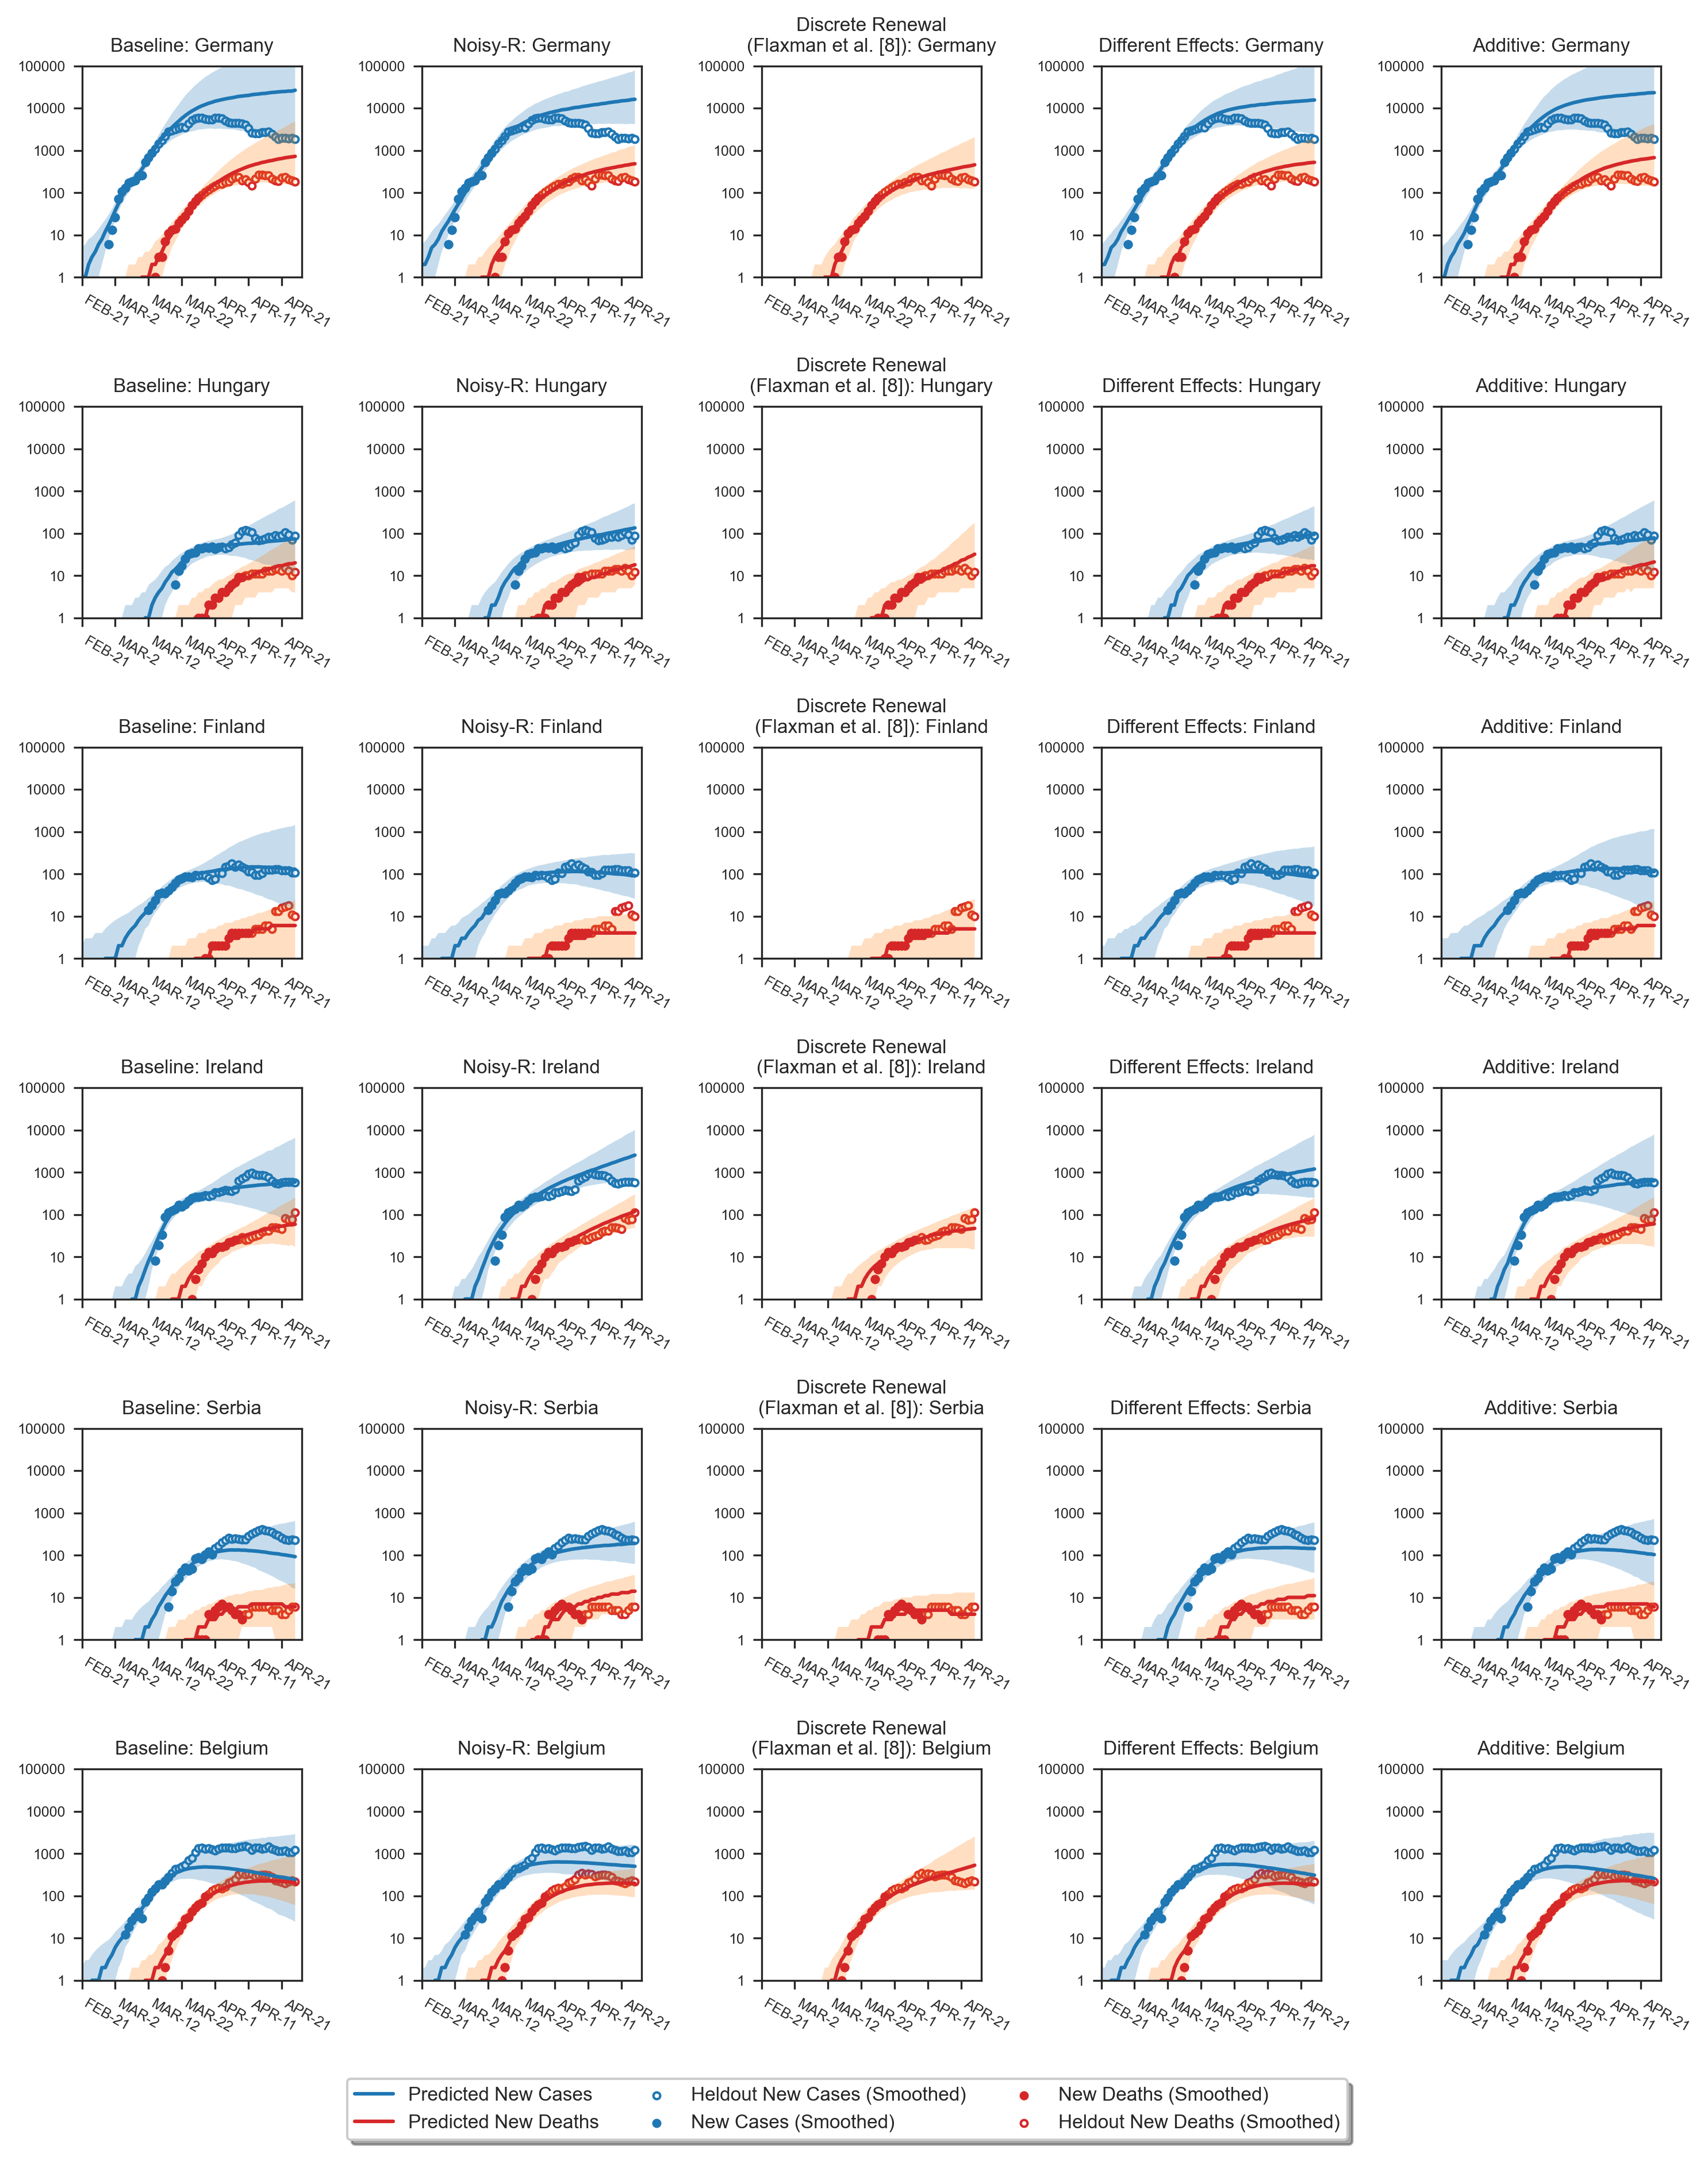

In [44]:
plt.figure(figsize=(10, 12), dpi=300)
model_names = ["Baseline", "Noisy-R", "Discrete Renewal\n(Flaxman et al. [8])", "Different Effects", "Additive"]
for m_i, model in enumerate([0, 1, 2, 3, 4]):
    ll1 = 0
    ll2 = 0
    c_ds = 0
    d_ds = 0
    for fold in [0]:
        rs = folds[fold]
        res = pickle.load(open(f"model_{model}_fold_{fold}.pkl", "rb"))   
#         plt.suptitle(model_names[model])
        alpha = np.mean(res.Phi)
        for i, r in enumerate(rs):
            plt.subplot(6, 5, 5*i + m_i+1)
            r_i = data.Rs.index(r)
            c_s, d_s = mask_region(data, r)
            n_cds = len(data.Ds) - c_s
            n_dds = len(data.Ds) - d_s
            
            ll1_inc = 0
            ll2_inc = 0
            mse1 = 0
            
            if model != 4:
                ec = res.ExpectedCases[:, i, :]
                dist = pm.NegativeBinomial.dist(mu=ec, alpha=np.mean(res.Phi))
                ec_output = dist.random()

                plt.plot(np.arange(len(data.Ds)), np.median(ec_output, axis=0), color="tab:blue", label="Predicted New Cases")
                plt.fill_between(np.arange(len(data.Ds)), np.percentile(ec_output,  2.5, axis=0) , np.percentile(ec_output,  97.5, axis=0), alpha=0.25, color="tab:blue", linewidth=0)
                plt.scatter(np.arange(len(data.Ds)), data.NewCases.data[r_i, :], edgecolor="tab:blue",
                facecolor="white", zorder=-1, s=8,  label="Heldout New Cases (Smoothed)")
                plt.scatter(np.arange(len(data.Ds)), data.NewCases[r_i, :], edgecolor="tab:blue", facecolor="tab:blue", zorder=-1, s=8,  label="New Cases (Smoothed)")

                conf_dist = pm.NegativeBinomial.dist(mu=res.ExpectedCases[:, i, c_s:], alpha=np.repeat(res.Phi.reshape((8000, 1)), n_cds, axis=1))     
                try:
                    ll1_inc = np.sum(np.log(np.mean(np.exp(conf_dist.logp(data.NewCases.data[r_i, c_s:].reshape((1, n_cds))).eval()))))
                except:
                    print(f"model: {model_names[model]}, region: {r}")
                    ll1_inc = 0
                mse1 = np.power(np.mean(np.power(np.median(res.ExpectedCases[:, i, c_s:], axis=0) - data.NewCases.data[r_i, c_s:], 2)), 0.5)

            ed = res.ExpectedDeaths[:, i, :]
            dist = pm.NegativeBinomial.dist(mu=ed, alpha=np.mean(res.Phi))
            ed_output = dist.random()

            plt.plot(np.arange(len(data.Ds)), np.median(ed_output, axis=0), color="tab:red", label="Predicted New Deaths")
            plt.fill_between(np.arange(len(data.Ds)), np.percentile(ed_output, 2.5,  axis=0) , np.percentile(ed_output, 97.5,  axis=0), alpha=0.25, color="tab:orange", linewidth=0)
            plt.scatter(np.arange(len(data.Ds)),  data.NewDeaths[r_i, :], edgecolor="tab:red", facecolor="tab:red", zorder=1, s=8,  label="New Deaths (Smoothed)")
            plt.scatter(np.arange(len(data.Ds)), data.NewDeaths.data[r_i, :], edgecolor="tab:red",
                facecolor="white", zorder=-1, s=8, label="Heldout New Deaths (Smoothed)")
            
            days = data.Ds
            min_x = 30
            max_x = 96
            locs = np.arange(min_x, max_x, 10)
            xlabels = [f"{month_to_str(days[ts].month)}-{days[ts].day}" for ts in locs]
            plt.xticks(locs, xlabels, rotation=-30, ha="left", fontsize=6)
            plt.yscale("log")
            plt.xlim([min_x, max_x])
            plt.ylim([1, 10**5])
            plt.title(f"{model_names[model]}: {data.RNames[r][0]}", fontsize=8)
            plt.yticks([1, 10, 100, 1000, 10000, 10**5], ["1", "10", "100", "1000", "10000", "100000"], fontsize=6)
plt.tight_layout()
plt.gca().legend(prop={"size": 8}, loc="lower center", shadow=True, fancybox=True, ncol=3, bbox_to_anchor=(-2.7, -0.8));
plt.savefig("holdouts.pdf", bbox_inches="tight")